In [1]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import pprint
import pyspark
import pyspark.sql.functions as F

from pyspark.sql.functions import col
from pyspark.sql.types import StringType, IntegerType, FloatType, DateType

import utils.data_processing_bronze_table
import utils.data_processing_silver_table
import utils.data_processing_gold_table


## set up pyspark session

In [2]:
# Initialize SparkSession
spark = pyspark.sql.SparkSession.builder \
    .appName("dev") \
    .master("local[*]") \
    .getOrCreate()

# Set log level to ERROR to hide warnings
spark.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/05 08:51:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## set up config

In [3]:
# set up config
snapshot_date_str = "2023-01-01"

start_date_str = "2023-01-01"
end_date_str = "2025-01-01"

In [4]:
# generate list of dates to process
def generate_first_of_month_dates(start_date_str, end_date_str):
    # Convert the date strings to datetime objects
    start_date = datetime.strptime(start_date_str, "%Y-%m-%d")
    end_date = datetime.strptime(end_date_str, "%Y-%m-%d")
    
    # List to store the first of month dates
    first_of_month_dates = []

    # Start from the first of the month of the start_date
    current_date = datetime(start_date.year, start_date.month, 1)

    while current_date <= end_date:
        # Append the date in yyyy-mm-dd format
        first_of_month_dates.append(current_date.strftime("%Y-%m-%d"))
        
        # Move to the first of the next month
        if current_date.month == 12:
            current_date = datetime(current_date.year + 1, 1, 1)
        else:
            current_date = datetime(current_date.year, current_date.month + 1, 1)

    return first_of_month_dates

dates_str_lst = generate_first_of_month_dates(start_date_str, end_date_str)
dates_str_lst

['2023-01-01',
 '2023-02-01',
 '2023-03-01',
 '2023-04-01',
 '2023-05-01',
 '2023-06-01',
 '2023-07-01',
 '2023-08-01',
 '2023-09-01',
 '2023-10-01',
 '2023-11-01',
 '2023-12-01',
 '2024-01-01',
 '2024-02-01',
 '2024-03-01',
 '2024-04-01',
 '2024-05-01',
 '2024-06-01',
 '2024-07-01',
 '2024-08-01',
 '2024-09-01',
 '2024-10-01',
 '2024-11-01',
 '2024-12-01',
 '2025-01-01']

## Build Bronze Table

In [5]:
# Define the 4 files to process
files_to_process = [
    "feature_clickstream.csv",
    "features_attributes.csv", 
    "features_financials.csv",
    "lms_loan_daily.csv"
]

# create bronze datalake directories for each file type
bronze_directories = {
    "clickstream": "datamart/bronze/clickstream/",
    "attributes": "datamart/bronze/attributes/",
    "financials": "datamart/bronze/financials/",
    "lms": "datamart/bronze/lms/"
}

for directory in bronze_directories.values():
    if not os.path.exists(directory):
        os.makedirs(directory)

In [6]:
# run bronze backfill for all files
for date_str in dates_str_lst:
    for file_type, directory in bronze_directories.items():
        utils.data_processing_bronze_table.process_bronze_table(
            date_str, directory, spark, file_type=file_type
        )

Processing bronze table for clickstream on 2023-01-01
Source file: data/feature_clickstream.csv
2023-01-01 row count: 8974
saved to: datamart/bronze/clickstream/bronze_clickstream_2023_01_01.csv
Processing bronze table for attributes on 2023-01-01
Source file: data/features_attributes.csv
2023-01-01 row count: 530
saved to: datamart/bronze/attributes/bronze_attributes_2023_01_01.csv
Processing bronze table for financials on 2023-01-01
Source file: data/features_financials.csv
2023-01-01 row count: 530
saved to: datamart/bronze/financials/bronze_financials_2023_01_01.csv
Processing bronze table for lms on 2023-01-01
Source file: data/lms_loan_daily.csv
2023-01-01 row count: 530
saved to: datamart/bronze/lms/bronze_lms_2023_01_01.csv
Processing bronze table for clickstream on 2023-02-01
Source file: data/feature_clickstream.csv
2023-02-01 row count: 8974
saved to: datamart/bronze/clickstream/bronze_clickstream_2023_02_01.csv
Processing bronze table for attributes on 2023-02-01
Source fil

In [7]:
# inspect output for all 4 files
clickstream_output = utils.data_processing_bronze_table.process_bronze_table(date_str, bronze_directories["clickstream"], spark, file_type="clickstream").toPandas()
attributes_output = utils.data_processing_bronze_table.process_bronze_table(date_str, bronze_directories["attributes"], spark, file_type="attributes").toPandas()
financials_output = utils.data_processing_bronze_table.process_bronze_table(date_str, bronze_directories["financials"], spark, file_type="financials").toPandas()
lms_output = utils.data_processing_bronze_table.process_bronze_table(date_str, bronze_directories["lms"], spark, file_type="lms").toPandas()

Processing bronze table for clickstream on 2025-01-01
Source file: data/feature_clickstream.csv
2025-01-01 row count: 0
saved to: datamart/bronze/clickstream/bronze_clickstream_2025_01_01.csv
Processing bronze table for attributes on 2025-01-01
Source file: data/features_attributes.csv
2025-01-01 row count: 526
saved to: datamart/bronze/attributes/bronze_attributes_2025_01_01.csv
Processing bronze table for financials on 2025-01-01
Source file: data/features_financials.csv
2025-01-01 row count: 526
saved to: datamart/bronze/financials/bronze_financials_2025_01_01.csv
Processing bronze table for lms on 2025-01-01
Source file: data/lms_loan_daily.csv
2025-01-01 row count: 5539
saved to: datamart/bronze/lms/bronze_lms_2025_01_01.csv


In [8]:
# Display first 10 samples for each file
print("CLICKSTREAM DATA (First 10 samples):")
print(clickstream_output.head(10))
print("\n" + "="*50)

print("ATTRIBUTES DATA (First 10 samples):")
print(attributes_output.head(10))
print("\n" + "="*50)

print("FINANCIALS DATA (First 10 samples):")
print(financials_output.head(10))
print("\n" + "="*50)

print("LMS DATA (First 10 samples):")
print(lms_output.head(10))

CLICKSTREAM DATA (First 10 samples):
Empty DataFrame
Columns: [fe_1, fe_2, fe_3, fe_4, fe_5, fe_6, fe_7, fe_8, fe_9, fe_10, fe_11, fe_12, fe_13, fe_14, fe_15, fe_16, fe_17, fe_18, fe_19, fe_20, Customer_ID, snapshot_date]
Index: []

[0 rows x 22 columns]

ATTRIBUTES DATA (First 10 samples):
  Customer_ID                 Name Age          SSN     Occupation  \
0  CUS_0x1009               Arunah  26  063-67-6938       Mechanic   
1  CUS_0x1098               Krudyz  23  466-10-5742        _______   
2  CUS_0x109f           Vellacottj  41  283-32-0255        Teacher   
3  CUS_0x10b6              Gillesw  49  439-76-5364     Journalist   
4  CUS_0x10e2              Sonalio  37  168-78-3262  Media_Manager   
5  CUS_0x114b              Hephero  37  978-19-7269   Entrepreneur   
6  CUS_0x11b7              Cremern  28  440-53-1294        Teacher   
7  CUS_0x11c1     Mark Felsenthalk  34  688-99-5258       Engineer   
8  CUS_0x11d9  Annika Breidthardtd  42  548-26-8600      Scientist   
9  CUS_0

## Build Silver Table

In [9]:
# create silver datalake directories for each file type
silver_directories = {
    "clickstream": "datamart/silver/clickstream/",
    "attributes": "datamart/silver/attributes/",
    "financials": "datamart/silver/financials/", 
    "lms": "datamart/silver/lms/" 
}

for directory in silver_directories.values():
    if not os.path.exists(directory):
        os.makedirs(directory)

In [10]:
# run silver backfill for all files
for date_str in dates_str_lst:
    for file_type, silver_directory in silver_directories.items():
        bronze_directory = bronze_directories.get(file_type, bronze_directories["lms"])
        utils.data_processing_silver_table.process_silver_table(
            date_str, bronze_directory, silver_directory, spark, file_type=file_type
        )


Processing silver table for clickstream on 2023-01-01
loaded from: datamart/bronze/clickstream/bronze_clickstream_2023_01_01.csv row count: 8974
Cleaning clickstream data for 2023-01-01
Normalizing data: clickstream_2023-01-01
Columns normalized
Normalized 1 string columns
Removed 0 duplicate rows
20 feature columns converted to numeric
saved to: datamart/silver/clickstream/silver_clickstream_2023_01_01.parquet
Processing silver table for attributes on 2023-01-01
loaded from: datamart/bronze/attributes/bronze_attributes_2023_01_01.csv row count: 530
Cleaning attributes data for 2023-01-01
Normalizing data: attributes_2023-01-01
Columns normalized
Normalized 5 string columns
Removed 0 duplicate rows
Cleaning age column
Median age from valid values: 34.0
Cleaning occupation column
Cleaning name column
Cleaning SSN column
saved to: datamart/silver/attributes/silver_attributes_2023_01_01.parquet
Processing silver table for financials on 2023-01-01
loaded from: datamart/bronze/financials/br

In [11]:
# inspect output for all 4 files
clickstream_output = utils.data_processing_silver_table.process_silver_table(
    date_str, 
    bronze_directories["clickstream"],  # Add bronze directory
    silver_directories["clickstream"], 
    spark, 
    file_type="clickstream"
).toPandas()

attributes_output = utils.data_processing_silver_table.process_silver_table(
    date_str, 
    bronze_directories["attributes"],  # Add bronze directory
    silver_directories["attributes"], 
    spark, 
    file_type="attributes"
).toPandas()

financials_output = utils.data_processing_silver_table.process_silver_table(
    date_str, 
    bronze_directories["financials"],  # Add bronze directory
    silver_directories["financials"], 
    spark, 
    file_type="financials"
).toPandas()

lms_output = utils.data_processing_silver_table.process_silver_table(
    date_str, 
    bronze_directories["lms"],  # Add bronze directory
    silver_directories["lms"], 
    spark, 
    file_type="lms"
).toPandas()

# Display first 10 samples for each file
print("CLICKSTREAM DATA (First 10 samples):")
print(clickstream_output.head(10))
print("\n" + "="*50)

print("ATTRIBUTES DATA (First 10 samples):")
print(attributes_output.head(10))
print("\n" + "="*50)

print("FINANCIALS DATA (First 10 samples):")
print(financials_output.head(10))
print("\n" + "="*50)

print("LMS DATA (First 10 samples):")
print(lms_output.head(10))

Processing silver table for clickstream on 2025-01-01
loaded from: datamart/bronze/clickstream/bronze_clickstream_2025_01_01.csv row count: 0
Cleaning clickstream data for 2025-01-01
Normalizing data: clickstream_2025-01-01
Columns normalized
Normalized 22 string columns
Removed 0 duplicate rows
20 feature columns converted to numeric
saved to: datamart/silver/clickstream/silver_clickstream_2025_01_01.parquet
Processing silver table for attributes on 2025-01-01
loaded from: datamart/bronze/attributes/bronze_attributes_2025_01_01.csv row count: 526
Cleaning attributes data for 2025-01-01
Normalizing data: attributes_2025-01-01
Columns normalized
Normalized 5 string columns
Removed 0 duplicate rows
Cleaning age column
Median age from valid values: 32.0
Cleaning occupation column
Cleaning name column
Cleaning SSN column
saved to: datamart/silver/attributes/silver_attributes_2025_01_01.parquet
Processing silver table for financials on 2025-01-01
loaded from: datamart/bronze/financials/bron

In [12]:
pip install openpyxl


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [13]:
import os

# Define output directory
output_dir = "excel_exports"
os.makedirs(output_dir, exist_ok=True)

# Export each DataFrame to Excel
clickstream_output.to_excel(os.path.join(output_dir, "clickstream_output.xlsx"), index=False, engine="openpyxl")
attributes_output.to_excel(os.path.join(output_dir, "attributes_output.xlsx"), index=False, engine="openpyxl")
financials_output.to_excel(os.path.join(output_dir, "financials_output.xlsx"), index=False, engine="openpyxl")
lms_output.to_excel(os.path.join(output_dir, "lms_output.xlsx"), index=False, engine="openpyxl")

print("All files exported successfully to the 'excel_exports' folder.")


All files exported successfully to the 'excel_exports' folder.


## EDA on credit labels

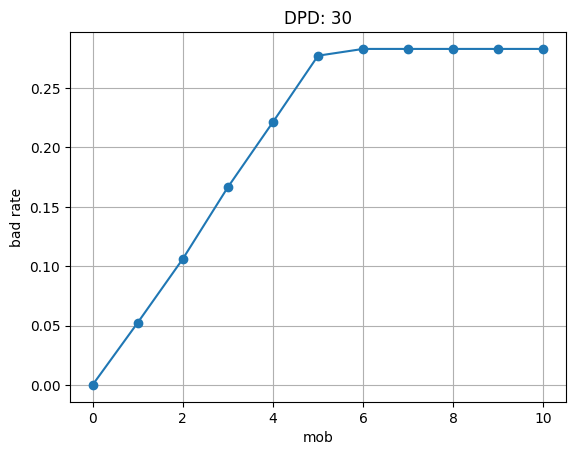

In [15]:
# set dpd label definition
dpd = 30

# Path to the folder containing CSV files
folder_path = silver_directory

# Read all CSV files into a single DataFrame
files_list = [folder_path+os.path.basename(f) for f in glob.glob(os.path.join(folder_path, '*'))]
df = spark.read.option("header", "true").parquet(*files_list)

# filter only completed loans
df = df.filter(col("loan_start_date") < datetime.strptime("2024-01-01", "%Y-%m-%d"))

# create dpd flag if more than dpd
df = df.withColumn("dpd_flag", F.when(col("dpd") >= dpd, 1).otherwise(0))

# actual bads 
actual_bads_df = df.filter(col("installment_num") == 10)

# prepare for analysis
# df = df.filter(col("installment_num") < 10)

# visualise bad rate
pdf = df.toPandas()

# Group by col_A and count occurrences in col_B
grouped = pdf.groupby('mob')['dpd_flag'].mean()

# Sort the index (x-axis) of the grouped DataFrame
grouped = grouped.sort_index()

# Plotting
grouped.plot(kind='line', marker='o')

plt.title('DPD: '+ str(dpd))
plt.xlabel('mob')
plt.ylabel('bad rate')
plt.grid(True)
plt.show()


Total loans: 5958
Actual bad loans (DPD >= 30 at final MOB): 1686


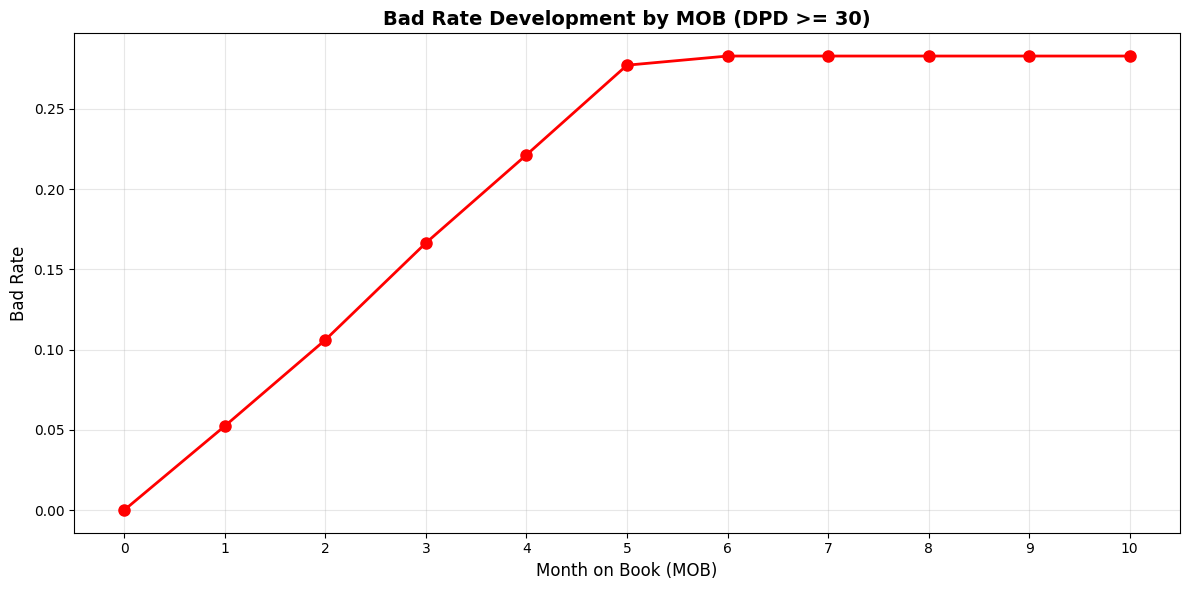

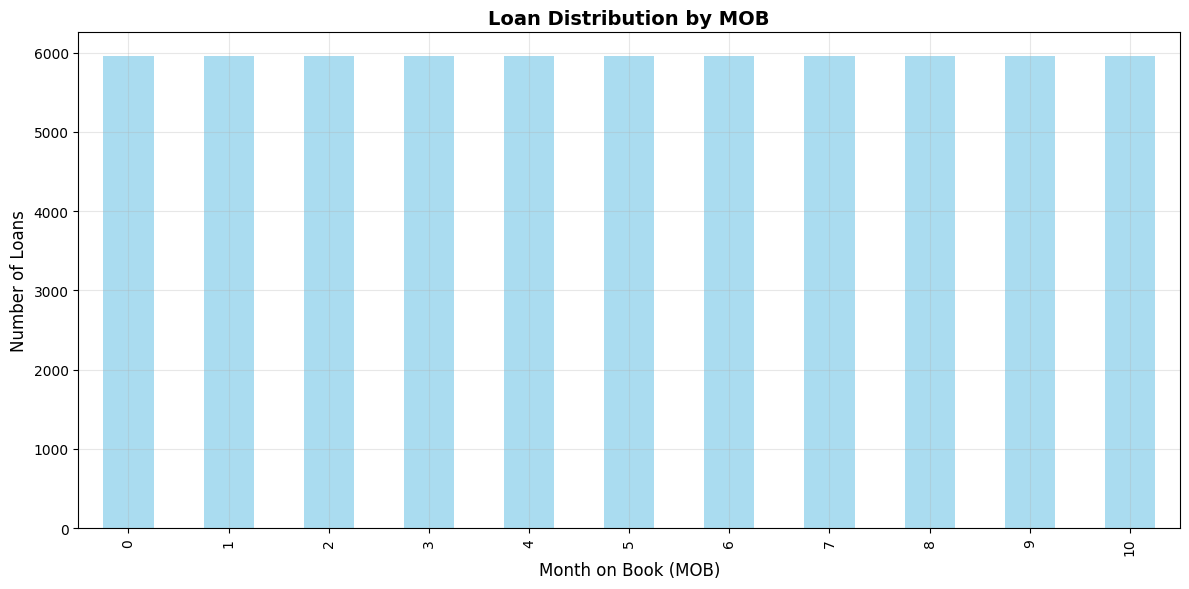

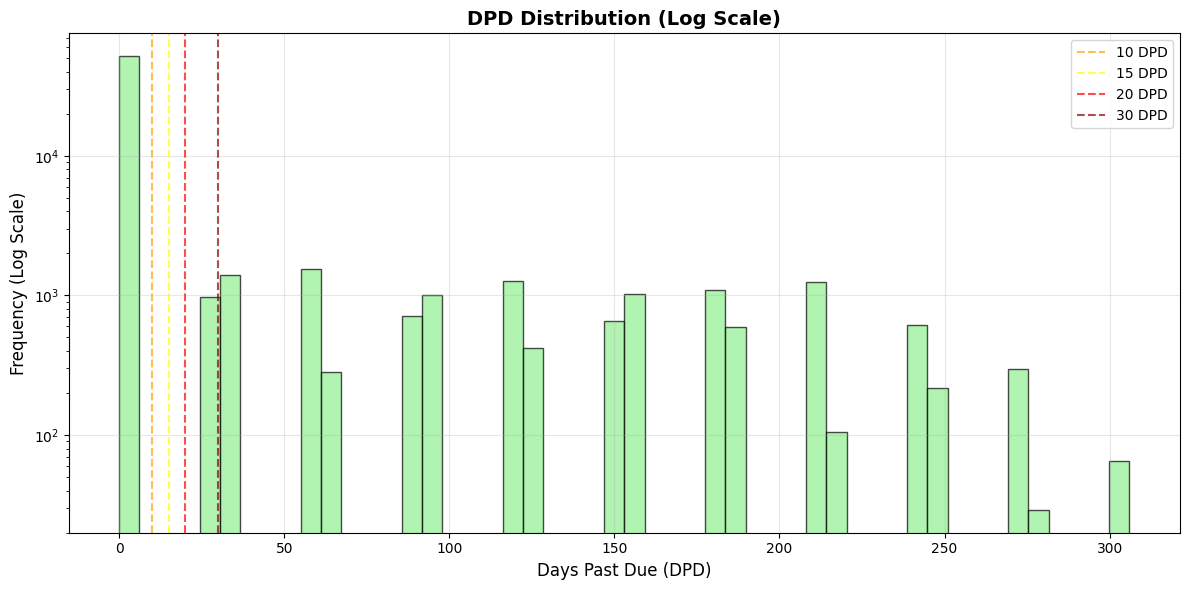

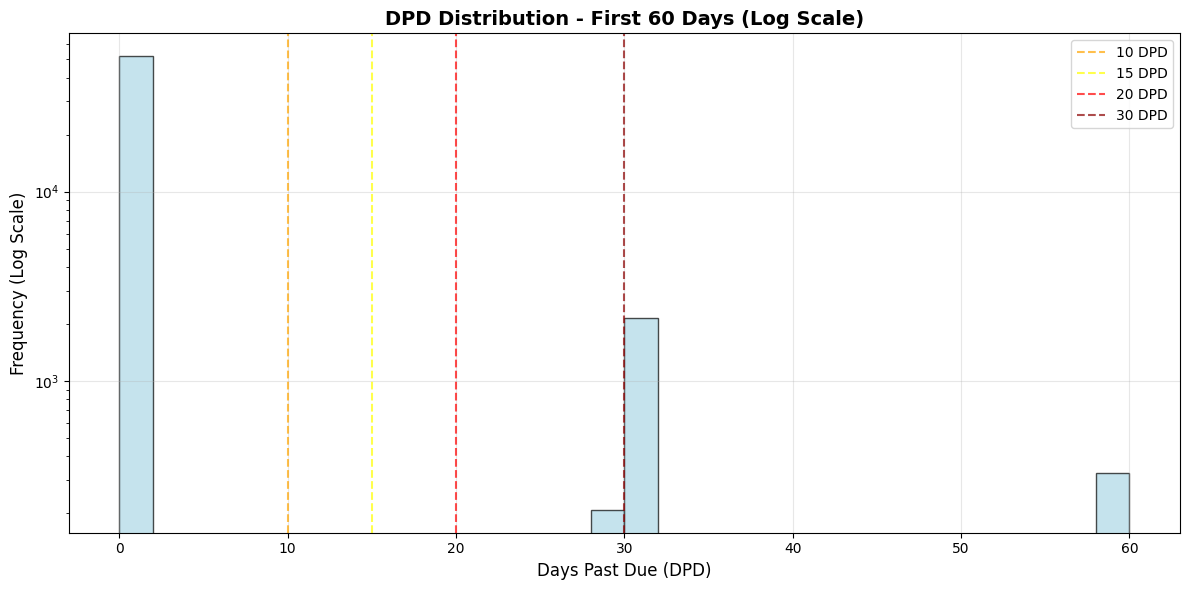


=== DPD Threshold Analysis ===
DPD >=  1:  13545 loans ( 20.67%)
DPD >=  5:  13545 loans ( 20.67%)
DPD >= 10:  13545 loans ( 20.67%)
DPD >= 15:  13545 loans ( 20.67%)
DPD >= 20:  13545 loans ( 20.67%)
DPD >= 30:  13337 loans ( 20.35%)
DPD >= 60:  11122 loans ( 16.97%)
DPD >= 90:   9324 loans ( 14.23%)

=== DPD by MOB (Mean) ===
MOB 0: Average DPD = 0.0 days
MOB 1: Average DPD = 1.8 days
MOB 2: Average DPD = 4.2 days
MOB 3: Average DPD = 8.0 days
MOB 4: Average DPD = 13.2 days
MOB 5: Average DPD = 21.8 days
MOB 6: Average DPD = 30.5 days
MOB 7: Average DPD = 39.1 days
MOB 8: Average DPD = 47.7 days
MOB 9: Average DPD = 56.4 days
MOB 10: Average DPD = 65.0 days

=== Summary Statistics ===
Total observations: 65538
Unique loans: 5958
MOB range: 0 to 10
DPD range: 0 to 306
Overall bad rate: 20.35%
Bad rate by MOB:
  MOB 0: 0.00% (5958 loans)
  MOB 1: 5.24% (5958 loans)
  MOB 2: 10.61% (5958 loans)
  MOB 3: 16.65% (5958 loans)
  MOB 4: 22.14% (5958 loans)
  MOB 5: 27.73% (5958 loans)
  MOB

In [16]:
# actual bads at final MOB (maximum installment_num for each loan)
# Get the max installment_num for each loan to find the final status
from pyspark.sql.window import Window

window_spec = Window.partitionBy("loan_id").orderBy(col("installment_num").desc())
df_with_rank = df.withColumn("rank", F.row_number().over(window_spec))
actual_bads_df = df_with_rank.filter(col("rank") == 1).filter(col("dpd_flag") == 1)

print(f"Total loans: {df.select('loan_id').distinct().count()}")
print(f"Actual bad loans (DPD >= {dpd} at final MOB): {actual_bads_df.count()}")

# prepare for analysis - look at bad rate development by MOB
# Use all data including MOB 10 for analysis
analysis_df = df

# visualise bad rate by MOB
pdf = analysis_df.toPandas()

# Group by mob and calculate bad rate
grouped = pdf.groupby('mob')['dpd_flag'].mean()

# Sort the index (x-axis) of the grouped DataFrame
grouped = grouped.sort_index()

# Plotting
plt.figure(figsize=(12, 6))
grouped.plot(kind='line', marker='o', color='red', linewidth=2, markersize=8)

plt.title(f'Bad Rate Development by MOB (DPD >= {dpd})', fontsize=14, fontweight='bold')
plt.xlabel('Month on Book (MOB)', fontsize=12)
plt.ylabel('Bad Rate', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(range(0, int(pdf['mob'].max()) + 1))
plt.tight_layout()
plt.show()

# Additional EDA - Loan distribution by MOB
plt.figure(figsize=(12, 6))
pdf['mob'].value_counts().sort_index().plot(kind='bar', color='skyblue', alpha=0.7)
plt.title('Loan Distribution by MOB', fontsize=14, fontweight='bold')
plt.xlabel('Month on Book (MOB)', fontsize=12)
plt.ylabel('Number of Loans', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# DPD distribution
# DPD distribution with log scale
plt.figure(figsize=(12, 6))
plt.hist(pdf['dpd'], bins=50, color='lightgreen', alpha=0.7, edgecolor='black', log=True)
plt.title('DPD Distribution (Log Scale)', fontsize=14, fontweight='bold')
plt.xlabel('Days Past Due (DPD)', fontsize=12)
plt.ylabel('Frequency (Log Scale)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.axvline(x=10, color='orange', linestyle='--', alpha=0.7, label='10 DPD')
plt.axvline(x=15, color='yellow', linestyle='--', alpha=0.7, label='15 DPD')
plt.axvline(x=20, color='red', linestyle='--', alpha=0.7, label='20 DPD')
plt.axvline(x=30, color='darkred', linestyle='--', alpha=0.7, label='30 DPD')
plt.legend()
plt.tight_layout()
plt.show()

# Also create a zoomed-in version for lower DPD values
plt.figure(figsize=(12, 6))
plt.hist(pdf[pdf['dpd'] <= 60]['dpd'], bins=30, color='lightblue', alpha=0.7, edgecolor='black', log=True)
plt.title('DPD Distribution - First 60 Days (Log Scale)', fontsize=14, fontweight='bold')
plt.xlabel('Days Past Due (DPD)', fontsize=12)
plt.ylabel('Frequency (Log Scale)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.axvline(x=10, color='orange', linestyle='--', alpha=0.7, label='10 DPD')
plt.axvline(x=15, color='yellow', linestyle='--', alpha=0.7, label='15 DPD')
plt.axvline(x=20, color='red', linestyle='--', alpha=0.7, label='20 DPD')
plt.axvline(x=30, color='darkred', linestyle='--', alpha=0.7, label='30 DPD')
plt.legend()
plt.tight_layout()
plt.show()

# Print detailed statistics around key DPD thresholds
print("\n=== DPD Threshold Analysis ===")
total_loans = len(pdf)
for threshold in [1, 5, 10, 15, 20, 30, 60, 90]:
    count_above = len(pdf[pdf['dpd'] >= threshold])
    percentage = (count_above / total_loans) * 100
    print(f"DPD >= {threshold:2d}: {count_above:6d} loans ({percentage:6.2f}%)")

# Additional analysis: DPD distribution by MOB
print("\n=== DPD by MOB (Mean) ===")
dpd_by_mob = pdf.groupby('mob')['dpd'].mean()
for mob in sorted(pdf['mob'].unique()):
    print(f"MOB {mob}: Average DPD = {dpd_by_mob[mob]:.1f} days")

# Print summary statistics
print("\n=== Summary Statistics ===")
print(f"Total observations: {len(pdf)}")
print(f"Unique loans: {pdf['loan_id'].nunique()}")
print(f"MOB range: {pdf['mob'].min()} to {pdf['mob'].max()}")
print(f"DPD range: {pdf['dpd'].min()} to {pdf['dpd'].max()}")
print(f"Overall bad rate: {pdf['dpd_flag'].mean():.2%}")
print(f"Bad rate by MOB:")
for mob in sorted(pdf['mob'].unique()):
    mob_data = pdf[pdf['mob'] == mob]
    bad_rate = mob_data['dpd_flag'].mean()
    count = len(mob_data)
    print(f"  MOB {mob}: {bad_rate:.2%} ({count} loans)")

## Build gold table for labels

In [17]:
# create gold datalake
gold_label_store_directory = "datamart/gold/label_store/"
gold_feature_store_directory = "datamart/gold/feature_store/"

if not os.path.exists(gold_label_store_directory):
    os.makedirs(gold_label_store_directory)

if not os.path.exists(gold_feature_store_directory):
    os.makedirs(gold_feature_store_directory)

In [18]:
# run gold backfill for labels
for date_str in dates_str_lst:
    utils.data_processing_gold_table.process_labels_gold_table(
        date_str, 
        silver_directories,  # Pass the dictionary, not individual directory
        gold_label_store_directory, 
        spark, 
        dpd=30, 
        mob=6
    )



loaded from: datamart/silver/lms/silver_lms_2023_01_01.parquet row count: 530
After filtering MOB=6, row count: 0
saved to: datamart/gold/label_store/gold_label_store_2023_01_01.parquet
loaded from: datamart/silver/lms/silver_lms_2023_02_01.parquet row count: 1031
After filtering MOB=6, row count: 0
saved to: datamart/gold/label_store/gold_label_store_2023_02_01.parquet
loaded from: datamart/silver/lms/silver_lms_2023_03_01.parquet row count: 1537
After filtering MOB=6, row count: 0
saved to: datamart/gold/label_store/gold_label_store_2023_03_01.parquet
loaded from: datamart/silver/lms/silver_lms_2023_04_01.parquet row count: 2047
After filtering MOB=6, row count: 0
saved to: datamart/gold/label_store/gold_label_store_2023_04_01.parquet
loaded from: datamart/silver/lms/silver_lms_2023_05_01.parquet row count: 2568
After filtering MOB=6, row count: 0
saved to: datamart/gold/label_store/gold_label_store_2023_05_01.parquet
loaded from: datamart/silver/lms/silver_lms_2023_06_01.parquet row

## inspect label store

In [19]:
folder_path = gold_label_store_directory
files_list = [folder_path+os.path.basename(f) for f in glob.glob(os.path.join(folder_path, '*.parquet'))]
if files_list:
    df = spark.read.option("header", "true").parquet(*files_list)
    print("label_store row_count:", df.count())
    df.show()
else:
    print("No label store files found")

label_store row_count: 9479
+--------------------+-----------+-----+----------+-------------+
|             loan_id|customer_id|label| label_def|snapshot_date|
+--------------------+-----------+-----+----------+-------------+
|cus_0x1037_2023_0...| cus_0x1037|    0|30dpd_6mob|   2023-07-01|
|cus_0x1069_2023_0...| cus_0x1069|    0|30dpd_6mob|   2023-07-01|
|cus_0x114a_2023_0...| cus_0x114a|    0|30dpd_6mob|   2023-07-01|
|cus_0x1184_2023_0...| cus_0x1184|    0|30dpd_6mob|   2023-07-01|
|cus_0x1297_2023_0...| cus_0x1297|    1|30dpd_6mob|   2023-07-01|
|cus_0x12fb_2023_0...| cus_0x12fb|    0|30dpd_6mob|   2023-07-01|
|cus_0x1325_2023_0...| cus_0x1325|    0|30dpd_6mob|   2023-07-01|
|cus_0x1341_2023_0...| cus_0x1341|    0|30dpd_6mob|   2023-07-01|
|cus_0x1375_2023_0...| cus_0x1375|    1|30dpd_6mob|   2023-07-01|
|cus_0x13a8_2023_0...| cus_0x13a8|    0|30dpd_6mob|   2023-07-01|
|cus_0x13ef_2023_0...| cus_0x13ef|    0|30dpd_6mob|   2023-07-01|
|cus_0x1440_2023_0...| cus_0x1440|    0|30dpd_6m

In [20]:
df.printSchema()

root
 |-- loan_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- label_def: string (nullable = true)
 |-- snapshot_date: date (nullable = true)



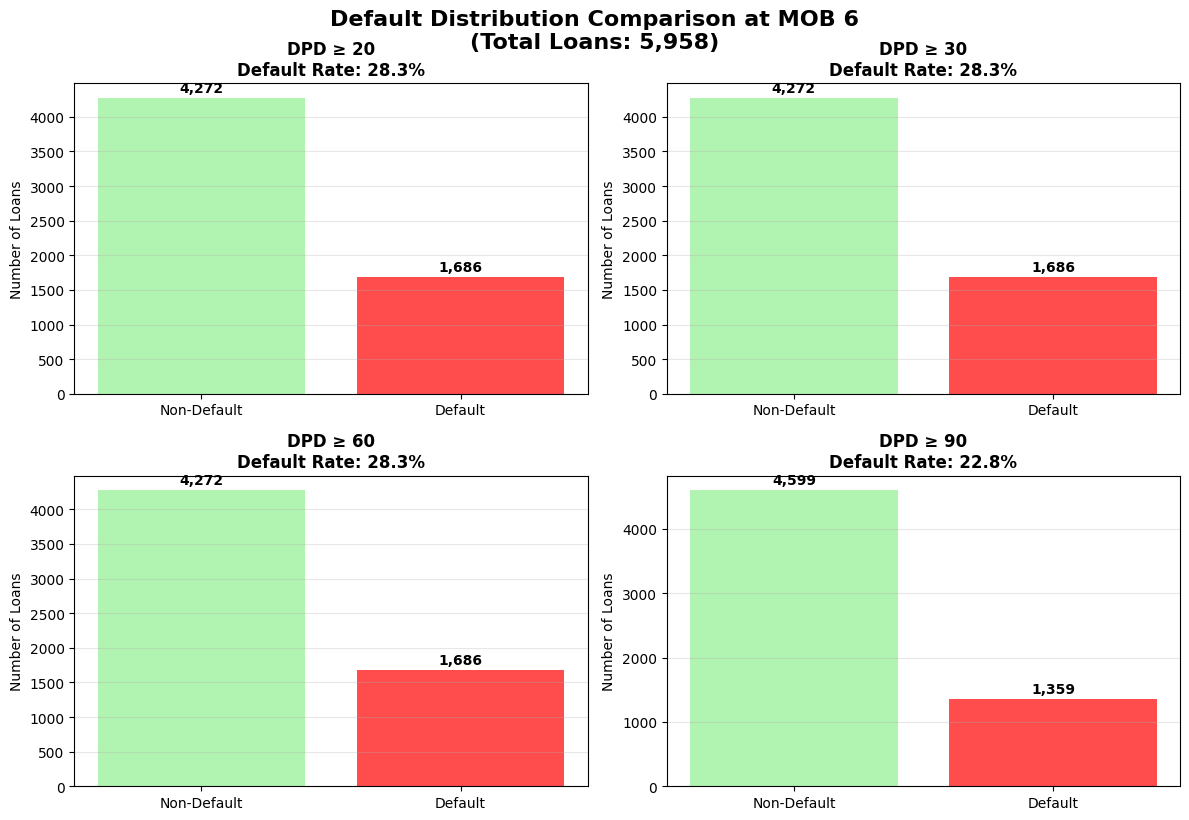

In [21]:
# Compare different DPD thresholds at MOB 6
plt.figure(figsize=(12, 8))

dpd_thresholds = [20, 30, 60, 90]
default_counts_list = []

for i, dpd_thresh in enumerate(dpd_thresholds):
    mob_6_data = pdf[pdf['mob'] == 6]
    default_count = (mob_6_data['dpd'] >= dpd_thresh).sum()
    non_default_count = len(mob_6_data) - default_count
    default_counts_list.append((non_default_count, default_count))
    
    # Create subplot for each threshold
    plt.subplot(2, 2, i+1)
    bars = plt.bar(['Non-Default', 'Default'], [non_default_count, default_count], 
                   color=['lightgreen', 'red'], alpha=0.7)
    
    # Add labels
    for bar, count in zip(bars, [non_default_count, default_count]):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max([non_default_count, default_count])*0.01, 
                f'{count:,}', ha='center', va='bottom', fontweight='bold')
    
    default_rate = (default_count / len(mob_6_data)) * 100
    plt.title(f'DPD ≥ {dpd_thresh}\nDefault Rate: {default_rate:.1f}%', fontweight='bold')
    plt.ylabel('Number of Loans')
    plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.suptitle(f'Default Distribution Comparison at MOB 6\n(Total Loans: {len(mob_6_data):,})', 
             fontsize=16, fontweight='bold', y=1.02)
plt.show()